Plot beaches lost and calculate some stats

In [103]:
# from BZ import *
import xarray as xr
import rioxarray as xrr
from shapely.geometry import box

import contextily as cx
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import img_tiles as cimgt
import seaborn as sns

from SL.SFEI import *

%matplotlib inline
%pdb off
    
print (os.getenv('CONDA_PROMPT_MODIFIER'), datetime.now())
# Rule: SetNull(CoNED < MLLW | (CoNED > ZT & ElNino > ZT)

Automatic pdb calling has been turned OFF
(SL)  2024-05-15 16:31:59.223369


# Setup

In [104]:
scen0   = 'med_rsl2050'
path_wd = Path(os.getenv('dataroot')) / 'Sea_Level' / 'SFEI'
use_s2  = False

## Constants
- Shouldnt have to change below here

In [105]:
path_res = path_wd / 'results'
regions = 'South Central North'.split()
scen = scen0.replace('_rsl', '')
s2_ext = '_s2' if use_s2 else ''

basemap_d = cimgt.GoogleTiles(url='https://server.arcgisonline.com/ArcGIS/rest/services/Elevation/World_Hillshade_Dark/MapServer/tile/{z}/{y}/{x}.jpg')
basemap   = cimgt.GoogleTiles(url='https://server.arcgisonline.com/arcgis/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}.jpg')
# basemap   = cimgt.GoogleTiles(url='https://www.google.cn/maps/vt?lyrs=s@189&gl=cn&x={x}&y={y}&z={z}'))

cxbasemap   = cx.providers.Esri.WorldImagery
cxbasemap_d = cx.providers.CartoDB.DarkMatter
cxbasemap_t = cx.providers.USGS.USTopo
            
projp = ccrs.PlateCarree()
GFS = GS  = 14 
TFS = 20 # title
XFS = YFS = 16 # x/y axis
GFS = 14 # deg marks
CFS = 18 # colorbar labels

pt_parms  = dict(verticalalignment='top', fontsize=20, color='w',
                bbox=dict(boxstyle='square,pad=0.05', facecolor='black'))

dct_proju = {'Central': ccrs.UTM(10), 'North': ccrs.UTM(10), 'South': ccrs.UTM(11)}

In [106]:
path_dems = path_wd / 'dems'
path_dems_all  = path_dems / 'all' # symlinked with everything

path_north   = path_dems / 'CA_north_coned_DEM_2020_9181'
gdf_north    = gpd.read_file(path_north / 'tileindex_CA_north_coned_DEM_2020.shp').to_crs(4326)

path_central = path_dems / 'CA_Central_CoNED_DEM_2017_8657'
gdf_central  = gpd.read_file(path_central / 'ca2017_central_coned_m8657.kmz').to_crs(4326)

path_south   = path_dems / 'CA_Southern_CoNED_DEM_2016_8658/'
gdf_south    = gpd.read_file(path_south / 'socal.kmz').to_crs(4326)

dct_gdf_bounds = {'South': gdf_south, 'Central': gdf_central, 'North': gdf_north}

In [107]:
## get the original cari; note that the shape and geojson are the same geometries despite geom_equals not saying so.
gdf_beach = gpd.read_file(path_wd  / 'CARI_polygons' / 'Cari_Beach.shp')
gdf_beach_wgs = gdf_beach.to_crs(4326)
sty_cari   = dict(facecolor='none', edgecolor='deeppink') 

## Helper Functions

In [108]:
def cut_polys(df_all_in, gdf_beach_in, pct_lost_max=100, area_min=0):
    """ Input for plot_bars """
    lst_poly_area = [] # for plotting hist and excluding outliers
    polys_to_drop = []
    for poly_ix, df_poly in df_all_in.groupby('poly_ix'):
        pct_lost  = (100 * df_poly[scen].mean())
        cari_poly = gdf_beach_in.loc[[poly_ix]]
        cari_area = cari_poly.area.item() # m2
        if (pct_lost > pct_lost_max) | (cari_area < area_min):
            polys_to_drop.append(poly_ix)
        lst_poly_area.append(cari_area) 
        # if np.isnan(cari_area):
        #     print (poly_ix)

    n_polys = df_all_in.groupby('poly_ix').count().shape[0]
    n_pct = 100 * len(polys_to_drop) / n_polys
    print (f'Dropping {len(polys_to_drop)} of {n_polys} polygons ({n_pct:.2f}%)')
    ## good; get rid of slivers
    df_all_new = df_all_in[~df_all_in.poly_ix.isin(polys_to_drop)]
    ser_pcts_new = {}
    for reg, df_reg in df_all_new.groupby('region'):
        ser_pcts_new[reg] = 100*(df_reg[scen].mean())
    
    ser_pcts_new['Total'] = 100*df_all_new[scen].mean()
    ser_pcts_new = pd.Series(ser_pcts_new)
    return df_all_new, ser_pcts_new, lst_poly_area


def plot_bars(ser_pcts_in):
    try:
        ser_pcts_in = ser_pcts_in.loc['South Central North Total'.split()]
    except:
        print ('Couldnt sort by regions')
    fig, axes = plt.subplots(figsize=(12, 6))
    sns.barplot(data=ser_pcts_in, ax=axes, color='dimgray')
    axes.set_ylabel('Beaches Lost (%)', fontsize=YFS)
    axes.set_xlabel('Region', fontsize=XFS)
    axes.tick_params(axis='both', labelsize=XFS-4)  
    axes.bar_label(axes.containers[0], fmt="{:.1f}%".format, fontsize=XFS-4);
    axes.grid(color='k', linestyle='--', alpha=0.1)
    return fig, axes


## Get Data
- each of these files is about 3 GB ---------- takes about two hours to load these
- a '1' in the column means the beach was lost

In [ ]:
dct_gdfs = {}
for region in regions:
    # if not region == 'North':
        # continue
    dst = path_res / f'{region}_beaches{s2_ext}.GeoJSON'
    assert dst.exists(),'Concatenate the beaches with BeachAnalysis.ipynb'
    print (f'Getting {region}...')
    dct_gdfs[region] = gpd.read_file(dst)
    print (f'Got existing beaches at: {dst}')
    # break

Getting South...


In [ ]:
lst_dfs  = []
dct_pcts = {}
for reg, gdf in dct_gdfs.items():
    df = pd.DataFrame(gdf.drop(columns='geometry'))
    df['region'] = reg
    lst_dfs.append(df)
    # compute the percentage for the region as a double check
    dct_pcts[reg] = 100*df[scen].sum()/df[scen].shape[0]

df_all = pd.concat(lst_dfs)
mem_use = df_all.memory_usage(deep=True).sum() * 1e-9  # Convert bytes to GB
print(f'Memory usage of DataFrame: {mem_use:.2f} GB')

ser_pcts = pd.Series(dct_pcts)
ser_pcts['Total'] = 100*df_all[scen].sum()/df_all.shape[0]

In [56]:
## get the pct_lost for each polygon and write to disk
ser_res = 100*df_all.groupby('poly_ix')[scen].sum() / df_all.groupby('poly_ix')[scen].count()
df_res = pd.DataFrame(ser_res).rename(columns=dict(scen=f'pct_lost_{scen}'))

cols   = 'CARI_id geometry'.split() if not use_s2 else 'geometry'
gdf_res = df_res.merge(gdf_beach.loc[df_res.index, cols], left_index=True, right_index=True)
gdf_res = gpd.GeoDataFrame(gdf_res, geometry='geometry')

dst = path_res / f'beach_loss_{scen}{s2_ext}.GeoJSON'
gdf_res.to_file(dst)
print (f'Wrote: {dst}')

Wrote: /scratch/tws_grace/data/Sea_Level/SFEI/results/beach_loss_med2050.GeoJSON


# Plot the Regions and Total Hist
- Requires 'Get Data' cells (~3 hours)

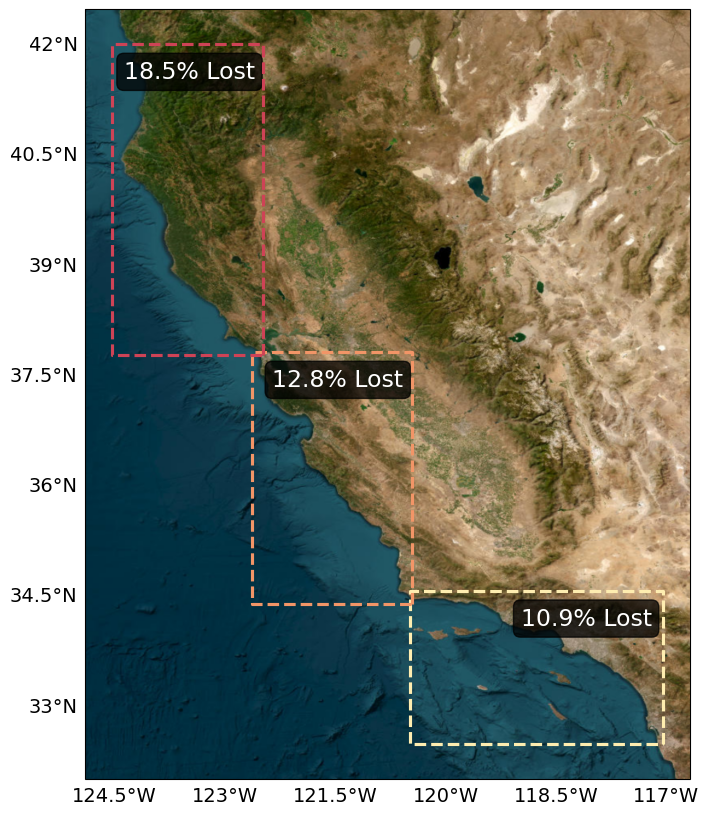

In [42]:
# dct_pct1 = {'North': 18.5, 'South': 10.9, 'Central': 12.8} # original, CARI

sty_name = dict(facecolor='black', alpha=0.75, boxstyle='round')

fig, axes = plt.subplots(figsize=(10, 10), subplot_kw={'projection': projp})
colors = plt.cm.get_cmap('cmo.matter')
# South, Central, North
colors = [colors(0.0), colors(0.25), colors(0.5)]
xys    = (0.72, 0.20), (0.31, 0.51), (0.065, 0.91)
for i, (reg, gdf) in enumerate(dct_gdf_bounds.items()):
    gdfb = gpd.GeoSeries(box(*gdf.total_bounds), crs=gdf.crs)
    lbl  = dct_pcts[reg]
    axes.text(*xys[i], f'{lbl:.1f}% Lost', transform=axes.transAxes, size=17, color='white', bbox=sty_name)
    gdfb.plot(ax=axes, facecolor='none', edgecolor=colors[i], linestyle='--', linewidth=2.25, transform=projp, zorder=50)
    
gl = axes.gridlines(draw_labels=True)
try:
    bbPlot.fmt_gridlines(gl, bottom=True, size=GFS)
except:
    pass
cx.add_basemap(ax=axes, crs=gdf.crs, source=cxbasemap, attribution=False)# zoom=10)

fig.set_label(f'Beaches_Lost_Overview{s2_ext}')
# bbPlot.savefigs(path_wd, True, True, dpi=300)

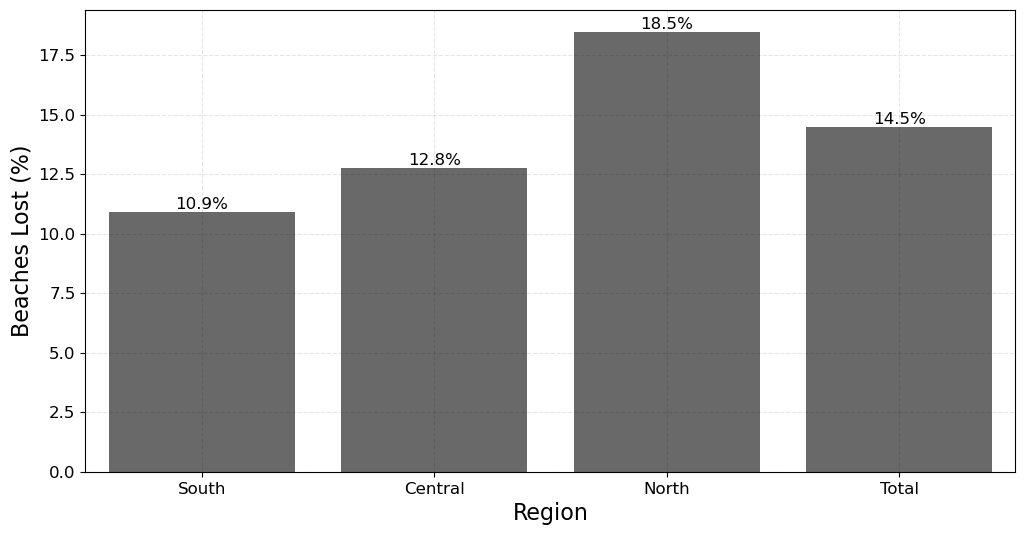

In [43]:
# nothing adjusted
plot_bars(ser_pcts);

## Cut by % lost

Dropping 110 of 6732 polygons (1.63%)


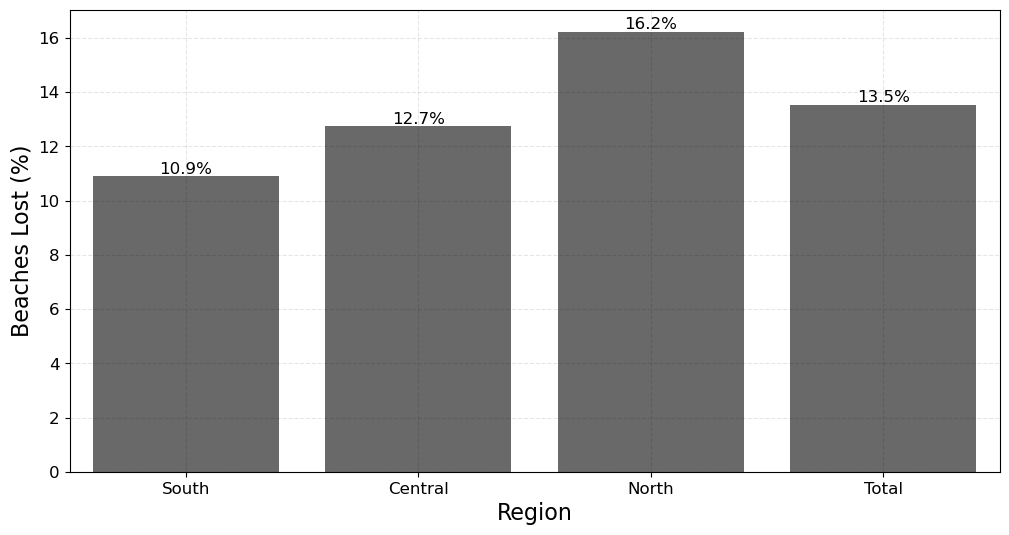

In [101]:
df_low, ser_pcts_low = cut_polys(df_all, gdf_beach, pct_lost_max=80)[:2]
plot_bars(ser_pcts_low);

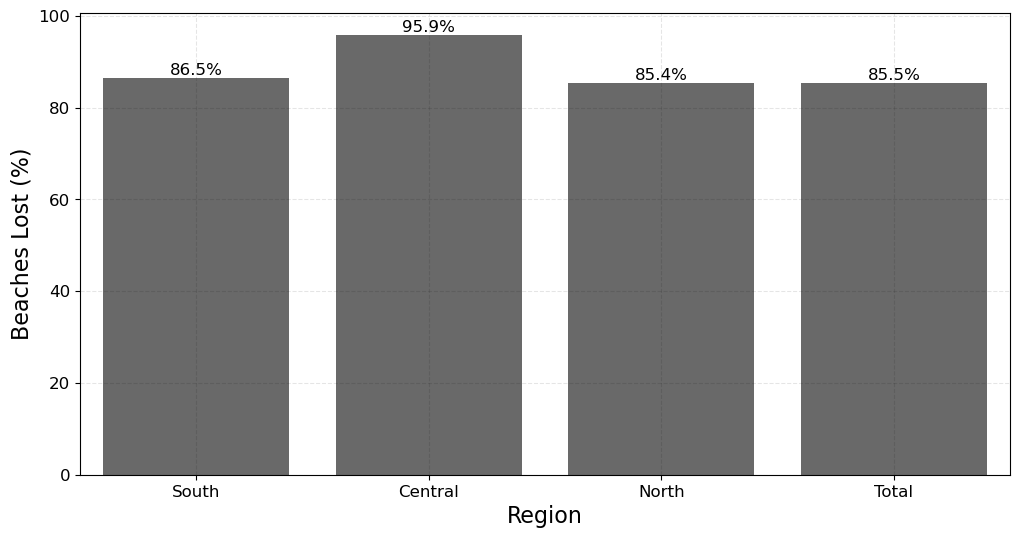

In [45]:
## just the above 80% polygons; should count them by region
df_high = df_all[~df_all.poly_ix.isin(df_low.poly_ix)]
ser_pcts_high = {}
for reg, df_reg in df_high.groupby('region'):
    ser_pcts_high[reg] = 100*df_reg[scen].sum()/df_reg[scen].shape[0]
# total... should be 80%
ser_pcts_high['Total'] = 100*df_high[scen].sum()/df_high[scen].shape[0]

plot_bars(pd.Series(ser_pcts_high));

## Cut by Area

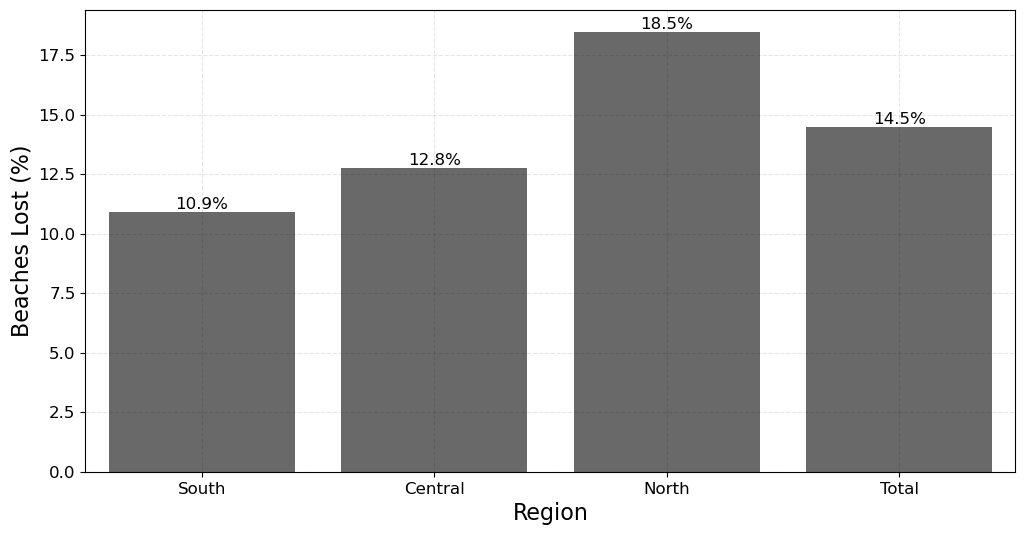

In [17]:
df_big1, ser_pcts_big1 = cut_polys(df_all, gdf_beach, area_min=1)[:2]
plot_bars(ser_pcts_big1);

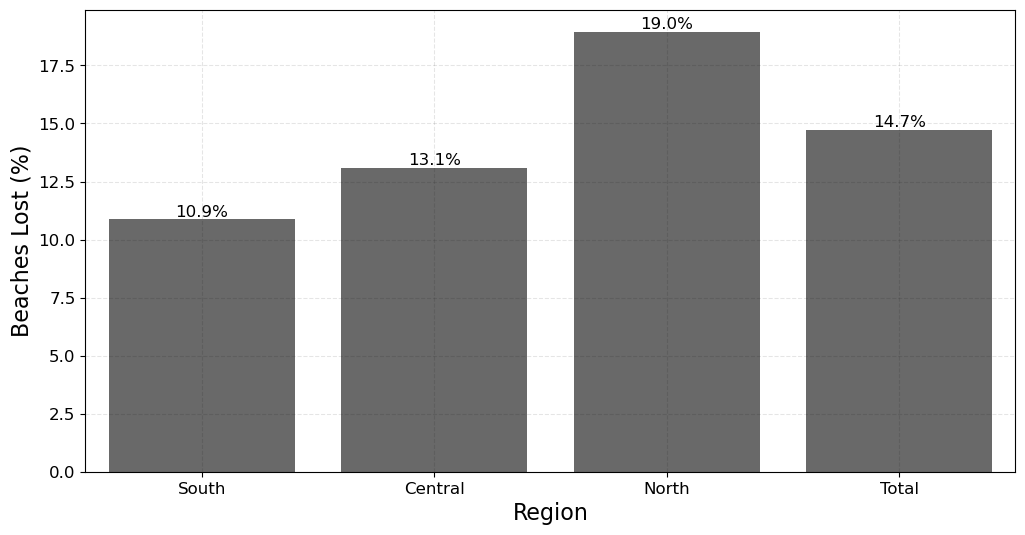

In [21]:
df_big2, ser_pcts_big2 = cut_polys(df_all, gdf_beach, area_min=10000)[:2]
plot_bars(ser_pcts_big2);

5%: 0.00, 95%: 44475.59
5%: 13066.60 +/- 96180.73 (
	1*lower_bound=-83114.13


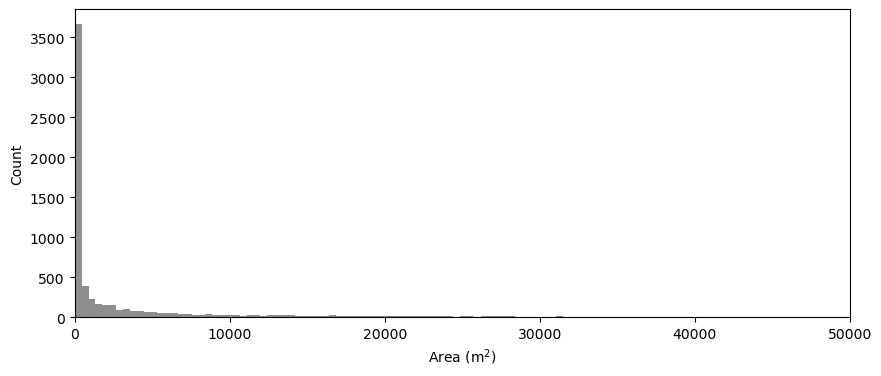

In [22]:
## plot the histogram to figure out where to cut; actually just use quantiles
lst_poly_area = cut_polys(df_all, gdf_beach, pct_lost_max=100, area_min=0)[2]
fig, axes = plt.subplots(figsize=(10, 4))
sns.histplot(lst_poly_area, kde=False, color='dimgray', ax=axes)
axes.set_xlim([0, 50000])
axes.set_xlabel('Area (m$^2$)')
print (f'5%: {np.nanquantile(lst_poly_area, 0.05):.2f}, 95%: {np.nanquantile(lst_poly_area, 0.95):.2f}')
print (f'5%: {np.nanmean(lst_poly_area):.2f} +/- {np.nanstd(lst_poly_area):.2f} (\n\t1*lower_bound={np.nanmean(lst_poly_area)-np.nanstd(lst_poly_area):.2f}')

# Quick Results
- Get the file of just polygons IDs and the percent lost

In [57]:
src = path_res / f'beach_loss_{scen}{s2_ext}.GeoJSON'
gdf_lost = gpd.read_file(src)
gdf_lost.head()

,poly_ix,med2050,CARI_id,geometry
0,0,11.151218,12,"POLYGON ((202772.510 -493273.469, 202769.710 -..."
1,1,5.788231,13,"POLYGON ((202520.731 -492772.764, 202521.231 -..."
2,2,0.000000,476,"POLYGON ((-278796.597 57720.716, -278809.400 5..."
3,3,0.000000,477,"POLYGON ((-279197.896 57989.678, -279207.293 5..."
4,4,25.095057,478,"POLYGON ((-282344.134 59846.100, -282341.743 5..."


In [67]:
thresh = 80
gdf_lost_high = gdf_lost[gdf_lost[scen] > thresh]
print (f'{gdf_lost_high.shape[0]} polygons lost more than {thresh}% of beaches')

110 polygons lost more than 80% of beaches


<Figure size 640x480 with 0 Axes>

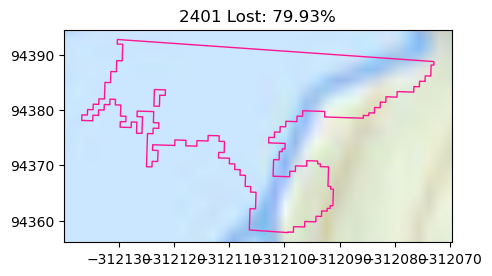

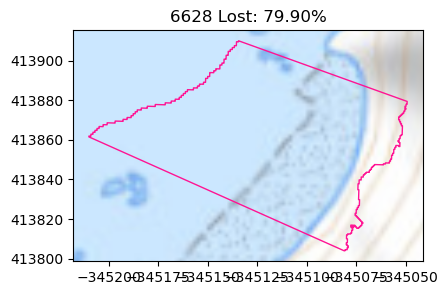

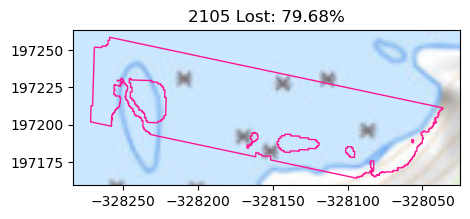

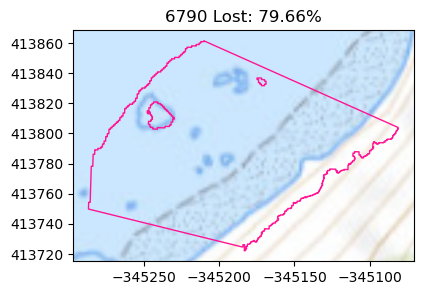

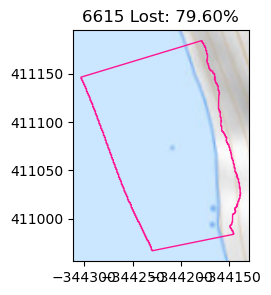

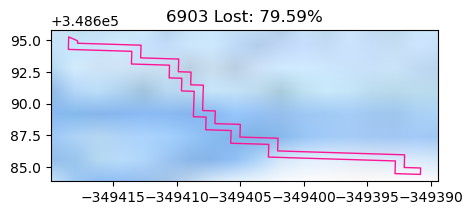

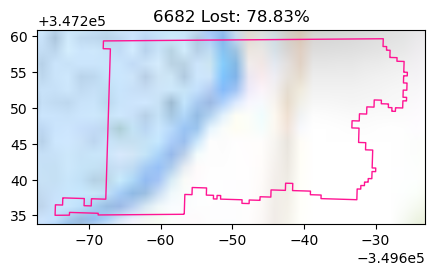

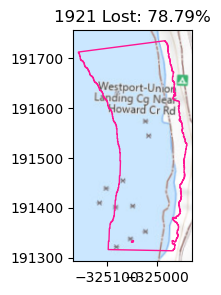

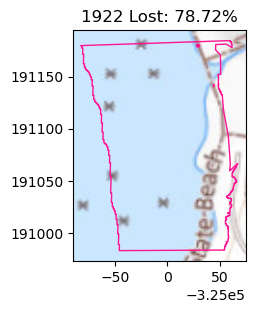

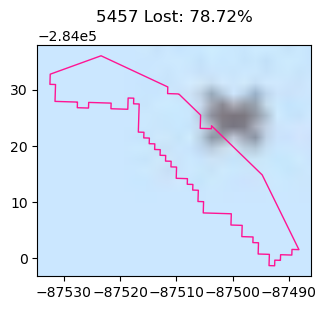

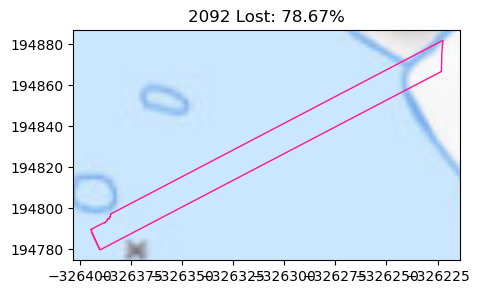

In [102]:
## plot some of the highest
n = 10
gdf_lost_good = gdf_lost[~gdf_lost.index.isin(gdf_lost_high.index)]

for i, ix in enumerate(gdf_lost_good.sort_values(scen, ascending=False).index):
    gdf_losti = gdf_lost_good.loc[[ix]]
    poly_ixi  = gdf_losti.poly_ix.item()
    pct_lost = gdf_losti[scen].item() 
    gdf_losti.buffer(50).plot(ax=axes, alpha=0) # make it a bit bigger
    fig, axes = plt.subplots(figsize=(5, 3))
    gdf_losti.plot(ax=axes, **sty_cari)
    cx.add_basemap(ax=axes, crs=gdf_lost.crs, source=cxbasemap_t, attribution=False, zoom=16)
    axes.set_title(f'{poly_ixi} Lost: {pct_lost:.2f}%');
    if i == n-1:
        break